# Chapter 5

In [174]:

from scm import SymbolicSCM
import sympy as sp
from query import Pr
from IPython.display import Latex

## Example 5.1 -- Hinton's Paradox

Imagine the case of a patient who needs to decide between two styles of treatment: an AI physician, who is a black box
and cannot explain itself, or a human physician, who is a medical doctor (MD) and can articulate
clear explanations for their decisions. Let $X$ represent the treatment, where $X = 0$ encodes the
MD, and $X = 1$ the AI system. Further, let $Y$ represent the patient’s health, where $Y = 0$ means
that the patient has died, and $Y = 1$ means that the patient is still alive after one year of treatment.
How should one choose between these two completely different styles of treatment?

Unbeknownst to physicians and patients, the following SCM encodes the true causal mechanisms of how patients naturally decide their treatment and further respond to it formally:

In [175]:
x, y, u = sp.symbols('X Y U')


scm_5_1 = SymbolicSCM(
    f={
        x: sp.Piecewise(
            (0, u < 4),
            (1,True)
        ),
        y: sp.Piecewise(
            (0, sp.Eq(u,0) | sp.Eq(u, 4)),
            (x, sp.Eq(u,1) | sp.Eq(u,5)),
            (1 - x, sp.Eq(u,2) | sp.Eq(u,6)),
            (1, True)
        )
    },
    pu = {
        u: [1/40,1/40,1/80,3/16,1/160,1/160,11/160,107/160]
    },
)

scm_5_1

SCM([X, Y], [U])

where $u = 0,1,...,7$. The endogenous variables $X$ and $Y$ are both binary and the exogenous variable $U$ is 8-dimensional, so as to represent the different types of preferences patients could have over treatments and how they respond to them.

From the perspective of the data analyst, who does not have access to $M^*$, one natural way of trying to answer the question of which treatment to recommend is to collect data on previous patients in the population who received these treatments and compute the statistics about the recovery rate for each treatment. This could be implemented with standard methods, including some of the most modern neural methods proposed by Hinton and collaborators.

In the limit, this is equivalent to computing the observational distribution, as discussed in Section 2.2.1, and as shown in Table 5.1.

In [176]:
table_5_1 = scm_5_1.get_probability_table(include_u=True)
table_5_1

,U,X,Y,probability
0,0,0,0,0.02500
1,1,0,0,0.02500
2,2,0,1,0.01250
3,3,0,1,0.18750
4,4,1,0,0.00625
5,5,1,1,0.00625
6,6,1,0,0.06875
7,7,1,1,0.66875


From the SCM, we have the following probabilities:

In [177]:
Latex('$$'+str(Pr({y:'y',x:'x'})) + r" = \sum_{u} 1(X(u) = x, Y(u) = y)P(u)"+'$$')

<IPython.core.display.Latex object>

In [178]:
Latex(f"$${str(Pr({x:'x'}))} = \sum_u 1(X(u) = x)P(u)$$")

<IPython.core.display.Latex object>

Let $u_i = P(U=i)$ then based on the table and the expressions above, the following quantities can be computed:

In [179]:
pgx1 = Pr({y:1},given={x:1})
pgx0 = Pr({y:1},given={x:0})

pjx1 = Pr({y:1,x:1})
pjx0 = Pr({y:1,x:0})

px1 = Pr({x:1})
px0 = Pr({x:0})

In [180]:
Latex('$$' + str(pgx1) + "=" + str(pjx1) + "/" + str(px1) + r'= u_5 + u_7 / u_4 + u_5 + u_6 + u_7' + '$$')

<IPython.core.display.Latex object>

The following quantities can be computed:

In [181]:
scm_5_1.query_exp(pgx1,latex=True)

<IPython.core.display.Latex object>

In [182]:
scm_5_1.query_exp(pjx1/px1,latex=True)

<IPython.core.display.Latex object>

In [183]:
table_5_1['probability'][table_5_1[u].isin([5,7])].sum() / table_5_1['probability'][table_5_1[u].isin([4,5,6,7])].sum()

0.8999999999999999

In [184]:
Latex('$$' + str(pgx0) + "=" + str(pjx0) + "/" + str(px0) + r'= u_2 + u_3 / u_0 + u_1 + u_2 + u_3' + '$$')

<IPython.core.display.Latex object>

The following quantities can be computed:

In [185]:
scm_5_1.query_exp(pgx0,latex=True)

<IPython.core.display.Latex object>

In [186]:
scm_5_1.query_exp(pjx0/px0,latex=True)

<IPython.core.display.Latex object>

In [187]:
table_5_1['probability'][table_5_1[u].isin([2,3])].sum() / table_5_1['probability'][table_5_1[u].isin([0,1,2,3])].sum()

0.8

Based on these results, someone unfamiliar with causal analysis may be tempted to conclude,
naturally, that the AI physician is to be preferred to the MD; if we are concerned solely with
maximizing the chances of survival, not the availability of explanation.

We understand from the discussion in the previous chapter that this is not the case. In particular, any quantity in the form of $P(Y \mid X = x)$, or more generally, any classifier $P(Y \mid X = x)$ trained from observational data, is suitable only for guessing survival rates, which includes spurious variations due to unobserved confounding. In fact, maximizing predictive accuracy (or minimizing mean squared error) in a predictive setting is an entirely different task, even though it is the most popular technique currently developed in AI, ML, and statistics. This quantity is valid when the goal is not to make a decision but to try to assess the probability of survival in a passive form.

Suppose certain policy-makers are not aware of this technical point and use these numbers to support a new regulation whereby AI physicians are deployed across the country, which means that patients will be uniformly submitted to treatment $do(X = 1)$. One valid question that follows from the discussion in the previous chapter would be – what is the effect of this new policy on the general population?

Again, $M^*$ can be used to evaluate this quantity through the standard definition of do-intervention (Def. 2.2.4), generating the sub-model $M_{X=1}$. Based on the potential responses and probabilities shown in Table 5.2, the target effects can be computed as:

In [188]:
py1_dx1 = Pr({y:1},do={x:1})

Latex('$$' + str(py1_dx1) + "=" + r"\sum_{u} 1(Y_{X=1}(u)=1)P(u)" '$$')

<IPython.core.display.Latex object>

In [189]:
table_5_2 = scm_5_1.do({x:1}).get_probability_table(include_u=True)
table_5_2

,U,{X}_{X=1},{Y}_{X=1},probability
0,0,1,0,0.02500
1,1,1,1,0.02500
2,2,1,0,0.01250
3,3,1,1,0.18750
4,4,1,0,0.00625
5,5,1,1,0.00625
6,6,1,0,0.06875
7,7,1,1,0.66875


In [190]:
table_5_2['probability'][table_5_2[u].isin([1,3,5,7])].sum()

0.8875

In [191]:
scm_5_1.query_exp(py1_dx1,latex=True)

<IPython.core.display.Latex object>

Likewise, what would happen in the hypothetical scenario in which human MDs make the decision $(do(X = 0))$, without any AI, which is associated with the following interventional distribution:

In [192]:
py1_dx0 = Pr({y:1},do={x:0})

Latex('$$' + str(py1_dx0) + "=" + r"\sum_{u} 1(Y_{X=0}(u)=1)P(u)" '$$')

<IPython.core.display.Latex object>

In [193]:
table_5_2_2 = scm_5_1.do({x:0}).get_probability_table(include_u=True)

In [194]:
table_5_2_2['probability'][table_5_2[u].isin([2,3,6,7])].sum()

0.9375

In [195]:
scm_5_1.query_exp(py1_dx0,latex=True)

<IPython.core.display.Latex object>

The equations above reveal that the result of the purported policy would be quite disastrous. Given the true causal mechanism $M$, it is clear that significantly more lives would be saved by relying on human doctors; on average, AI is currently hurting more people than helping.

This example highlights what we already know: the analysis and the type of claim that can be
made about reality are contingent on how the data was collected, evident from the perspective of
the PCH’s layers.

Let us consider now going a bit further up on the PCH, and ask about the probability of survival under a specific treatment, given that the patient is inclined to opt for the other treatment. For concreteness, the patient is tempted to go with the AI system ($X = 1$), given their age group, gender, socioeconomic status, personality, and other factors, and may wonder whether they would survive ($Y = 1$) had they been treated by the human ($X = 0$). This query has special meaning in the language of L3, and is written as the counterfactual statement:

In [196]:
y_x0 = scm_5_1.do({x:0}).v['Y']

py1_x0_gx1 = Pr({y_x0:1},given={x:1})

py1_x0_gx1

P\left({Y}_{X=0} = 1 \mid X = 1\right)

In other words, what would the potential outcome $Y_{X=0}$ be for those individuals who would naturally choose treatment $X = 1$. This quantity is sometimes called the effect of treatment on the treated (ETT, for short). For convenience, we can re-write the ETT as the following ratio:

In [197]:
Latex('$$' + str(py1_x0_gx1) + "=" + str(Pr({y_x0:1,x:1})) + "/" + str(Pr({x:1})) +'$$')

<IPython.core.display.Latex object>

Now we consider the evaluation through the SCM $M$. Note that the denominator is a $L_1$-quantity computed earlier, so we focused on the numerator. The same can be evaluated by $M$, as discussed in Section 2.1 (and following Def. 2.2.6), through the following equation (and Table 5.2):

In [198]:
Latex('$$' + str(py1_x0_gx1) + "=" + r"\sum_{u} 1(Y_{X=0}(u)=1, X(u) = 1)P(u)" '$$')

<IPython.core.display.Latex object>

In [199]:
table_5_2_2['probability'][table_5_2_2[u].isin([6,7])].sum()

0.7374999999999999

The same evaluation process can be performed for the other instantiations, leading to the following
counterfactual distributions:

In [200]:
y_x1 = scm_5_1.do({x:1}).v.Y

In [201]:
display(scm_5_1.query_exp(Pr({y_x1:1},given={x:0}),latex=True))
display(scm_5_1.query_exp(Pr({y_x0:1},given={x:0}),latex=True))
display(scm_5_1.query_exp(Pr({y_x1:1},given={x:1}),latex=True))
display(scm_5_1.query_exp(Pr({y_x0:1},given={x:1}),latex=True))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In words, among those patients inclined to opt for the MD ($X = 0$ after the conditioning bar), being
treated by the AI physician ($X = 1$) would be better since:

In [202]:
scm_5_1.query_exp(Pr({y_x1:1},given={x:0}) > Pr({y_x0:1},given={x:0}),latex=True)

<IPython.core.display.Latex object>

On the other hand, for patients inclined to prefer the AI physician, going with the MD would lead
to better outcomes and possible survival since:

In [203]:
scm_5_1.query_exp(Pr({y_x1:1},given={x:1}) < Pr({y_x0:1},given={x:1}), latex=True)

<IPython.core.display.Latex object>

Knowing these additional, quintessentially layer 3 facts, the best policy would actually be to give
patients whatever treatment they would be inclined not to choose.

Let us climb up on the PCH a bit more and ask about the probability of survival under a specific treatment, given that the patient opted for the other treatment and observed a certain outcome. For instance, the patient was treated by the AI system ($X = 1$), given their age group, gender, socioeconomic status, personality, etc., and ended up dead ($Y = 0$); we now wonder: would they have survived ($Y = 1$) had they been treated by the human physician ($X = 0$). This is a quintessential L3-quantity and can be written as the counterfactual statement:

In [204]:
Pr({y_x1:1},given={x:0,y:0})

P\left({Y}_{X=1} = 1 \mid X = 0, Y = 0\right)

In words, what would have been the potential outcome $Y_{X=1}$ for individuals who have naturally chosen treatment $X = 0$ and died ($Y = 0$)? This quantity is sometimes called the probability of necessity (PN, for short). For convenience, we can re-write the PN as the following ratio:

In [205]:
Latex("$"+str(Pr({y_x1:1},given={x:0,y:0})) + "=" + str(Pr({y_x1:1,x:0,y:0})) + "/" + str(Pr({x:0,y:0})) + "$")

<IPython.core.display.Latex object>

First, we can immediately ignore the denominator again since it is entirely determined as an $L_1$-quantity. More interestingly, note that the numerator contains the event where the variable $Y$ has the subscript that includes the variable $X$, i.e., $Y_{X=1}$, while the second and third variables represent an event in the factual world, ($X = 0, Y = 0$), which actually happened. This constitutes the very essence of counterfactuals since we have variables living in distinct worlds, $Y$ living in the $do(X = 1)$ world, while $X$, $Y$ themselves live in the natural world, without any intervention.

Now we consider the evaluation of the numerator of Eq. (5.22) through the SCM $M$, as discussed in Section 2.1 (and following Def. 2.2.6), through the following equation and Table 5.2:

In [206]:
Latex('$$' + str(Pr({y_x1:1,x:0,y:0})) + "=" + r"\sum_{u} 1(Y_{X=1}(u)=1, X(u) = 0, Y(u) = 0)P(u)" '$$')

<IPython.core.display.Latex object>

The same evaluation process can be performed for the other instantiations, leading to the following
results:

In [207]:
q = scm_5_1.query_exp

display(
q(Pr({y_x1:1},given={x:0,y:0}),latex=True),
q(Pr({y_x0:1},given={x:0,y:0}),latex=True),
q(Pr({y_x1:1},given={x:0,y:1}),latex=True),
q(Pr({y_x0:1},given={x:0,y:1}),latex=True),
q(Pr({y_x1:1},given={x:1,y:0}),latex=True),
q(Pr({y_x0:1},given={x:1,y:0}),latex=True),
q(Pr({y_x1:1},given={x:1,y:1}),latex=True),
q(Pr({y_x0:1},given={x:1,y:1}),latex=True)
)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In words, among those patients who naturally opted for the MD and are dead ($X = 0, Y = 0$ after the conditioning bar), treatment by the AI physician ($X = 1$) would be better since:

In [208]:
q(Pr({y_x1:1},given={x:0,y:0}) > Pr({y_x0:1},given={x:0,y:0}),latex=True)

<IPython.core.display.Latex object>

On the other hand, for patients inclined to prefer the AI physician and who died ($X = 1, Y = 0$), going with the MD would lead to better outcomes and possible survival since:

In [209]:
q(Pr({y_x1:1},given={x:0,y:1}) < Pr({y_x0:1},given={x:0,y:1}),latex=True)

<IPython.core.display.Latex object>

Interestingly, the counterfactual quantities discussed above are not obtainable through any physical experiment. The reason is that after the person took the drug and died, there is no way we could bring them back from the other side to be submitted to an alternative treatment.

Nevertheless, this counterfactual quantity contains significant meaning for attribution of responsibility since it may represent that the drug manufacturer is guilty since, counterfactually, the person would have been alive had they not taken the drug. The lesson is broader and independent of exactly $X$ and $Y$.

## Example 5.2 -- Counterfactuals and Salary Estimation

We now consider the case of understanding the salary of employees in a certain firm. Data is collected for each employee where $EX$ represents their experience in years, $ED$ their education level ('0': high school degree, '1': college degree, '2': graduate degree), and $S$ their salary.


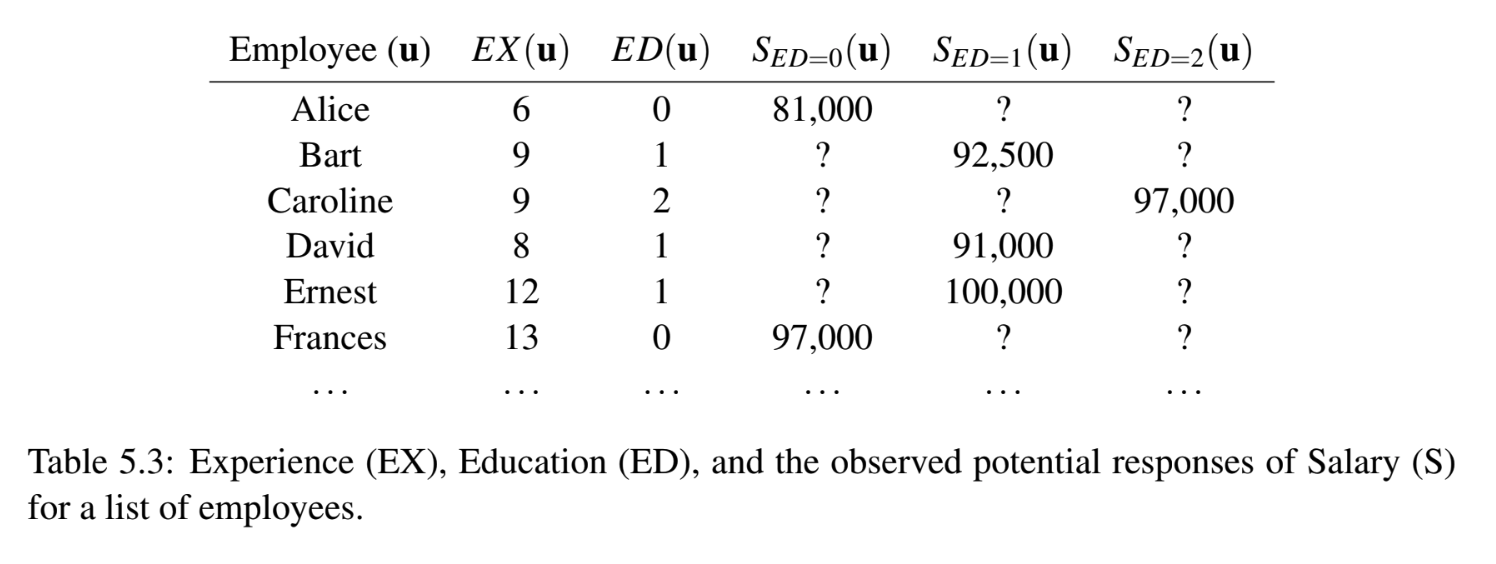

Suppose we are interested in Alice’s salary had she attended college, that is, $S_{ED=1}(Alice)$. One naive answer to this question is to use linear regression to estimate Salary as a linear combination of Experience and Education, which leads to the following equation:

$$S = 65,000 + 2,500EX + 5,000ED$$

To answer the question about Caroline's salary, one may be tempted to say:

$$S_{ED=1}(Alice) = 65,000 + 25,00(6) + 5,000(1) = 85,000$$

However, this approach is oblivious to the fact that changing the Education level may also
affect the Experience gained by the employee. As we have seen before, data-driven strategies
cannot assess layer 2 queries, much less layer 3 counterfactuals, because they are oblivious to the
underlying causal structure.

For the sake of illustration, consider the following structural causal models with linear functions (for simplicity):

## Counterfactual Quantities

## Theorem 5.2.1 -- Structural Basis Expansion of Counterfactuals
Consider an SCM $M^*$ and a counterfactual distribution computed from it,
$$P[Y_C|E]$$
where E is the factual evidence, C is the counterfactual condition, and Y is the outcome variable.

We can write the structural basis expansion:
$$\sum_u 1[Y_C (u) = y]P(u|E=e)$$



We can understand this through a three-step counterfactual evaluation:

1. **Abduction.** Based on the factual evidence E = e, the posterior distribution over th eunits can be computed to better explain the evidence, namely, $P(U|E=e)$.
   
2. **Intervention.** Based on the counterfactual condition, C = c, the corresponding sub-model, $F_{C=c}$ can be generated.
   
3. **Evaluation.** With a new probability distribution over the exogenous (from step 1) and a new collection of mechanisms (from step 2), both over the same set of endogenous and exogenous variables, a new SCM is induced, namely:
$$M' = (U, V, F_{C=c},P(U|E))$$

## Effect of the Treatment on the Treated (ETT)

The ETT mixes the natural and the counterfactual words, or variations in layers 1 and 2, and is written as follows:

$$P(Y_{X=x}|X=x')$$

We can write the structural basis expansion:

$$\sum_u 1[Y_{X=x}(u)=y]P(U|X=x')$$

### Example 5.3 -- Job Re-training Program

The government is considering funding a new re-training program to get unemployed citizens back into the workforce by acquiring new skills to build AI systems. The structural model describing this population is given below:

In [210]:
x, y, u = sp.symbols('x y u')

scm_5_3 = SymbolicSCM(
    f = {
        x: sp.Piecewise((0, u < 2), (1, True)),
        y: sp.Piecewise((x, sp.Eq(u,0) | sp.Eq(u,2)), (1 - x, sp.Eq(u,1) | sp.Eq(u,3)), (1, True))
    },
    
    pu ={
        u: [9/40,7/40,1/5,1/5,1/5]
    }
)

The variable X represents whether the person enrolled in the program, and Y whether the person was able to find a new job one year after graduating.

Evidence shows that the program is effective:

In [211]:
y_x1 = scm_5_3.do({x:1}).v['y']

y_x0 = scm_5_3.do({x:0}).v.y

In [212]:
scm_5_3.query({y_x1:1}) - scm_5_3.query({y_x0:1}) > 0

True

Hiring rate among the program participants turns out to be even higher than in the original pilot study, formally:

In [213]:
scm_5_3.query({y:1},given={x:1}) - scm_5_3.query({y_x1:1}) > 0

True

Yet, those who self-enroll, critics say, are more resourceful, more intelligent, and socially more
connected than the eligible who did not enroll and are more likely to have found a job regardless
of whether receiving or not the training.

Mathematically, the data scientist suggests we need to estimate the program’s differential ben-
efit on those who enrolled. To what extent does the hiring rate increase among those who enroll,
compared to what it would have been had they not been trained, which is written as the following
ETT contrast:

In [214]:
scm_5_3.query({y_x1:1},given={x:1}) - scm_5_3.query({y_x0:1},given={x:1}) > 0

False

In other words, this contrast compares two different counterfactual worlds for units that would naturally join the training program, $X = 1$.

It relates to the difference in their employability (outcome $Y$) had they enroll ($do(X = 1)$) versus
not enroll ($do(X = 0)$) into the program, or $Y_{X=1}$ versus $Y_{X=0}$.

## Probabilities of Necessity & Sufficiency

We now consider a pair of quantities known as the probability of necessity (PN) and the probability
of sufficiency (PS), which are written as:

$$PS(X;Y) = P(Y_{X=1}=1|X=0,Y=0)$$
$$PN(X;Y) = P(Y_{X=0}|X=1,Y=1)$$

PS encodes how much the presence of X is sufficient to make Y = 1.

PN encodes how much the presence of X was necessary to make Y = 1.
\
\
\
We can define this more generally as:
$$PN/PS_{(x,y),(x',y')}(X;Y) = P(Y_{X=x} | X=x', Y=y')$$

Through structural basis decomposition, we obtain:
$$\sum_u 1[Y_{X=x}(u)=y]P(u|X=x',Y=y')$$

### Example 5.5 -- Medical Decisions

Consider an example that appears in the context of medical decision-making:

In [215]:
x, y, z, ur, ux, uy, uz = sp.symbols('x y z ur ux uy uz')

scm_5_5 = SymbolicSCM(
    f = {
        z: ur & uz,
        x: ~(z ^ ux),
        y: (x & ur) | (~x & ur & uy) | (~x & ~ur & ~uy)
    },
    pu = {
        ur: .25,
        uz: .95,
        ux: .9,
        uy: .7
    }
)
        

where $X$ represents a drug, $Y$ the outcome of survival, and $Z$ the presence or not of a symptom (hypertension). $U_r$ represents whether a person has a specific natural resistance to the disease, and $U_x, U_y, U_z$ are sources of variations outside the model affecting $X, Y, Z$, respectively.

In [216]:
scm_5_5_do_x0 = scm_5_5.do({x:0})

scm_5_5_do_x1 = scm_5_5.do({x:1})

In [217]:
df = scm_5_5.get_probability_table(include_u=True)
df_x0 = scm_5_5_do_x0.get_probability_table(symbols={y},include_u=True).iloc[:,-2]
df_x1 = scm_5_5_do_x1.get_probability_table(symbols={y},include_u=True).iloc[:,-2]
df.insert(len(df.columns) - 1,df_x0.name,df_x0)
df.insert(len(df.columns) - 1,df_x1.name,df_x1)

table_5_5 = df

In [218]:
scm_5_5.query({y:1},given={x:1}) - scm_5_5.query({y:1},given={x:0}) > 0

True

One may seem to conclude that because the probability of survival ($Y=1$) given that one took the drug ($X=1$) is higher than without ($X=0$), that the drug has a positive effect. At this point though, our readers know better, so we look at the causal effect of the drug:

In [219]:
y_x1 = scm_5_5_do_x1.v.y
y_x0 = scm_5_5_do_x0.v.y

scm_5_5.query({y_x1:1}) - scm_5_5.query({y_x0:1}) > 0

False

Thus, interventionally speaking, the drug has a negative (average) effect in the population.

Since there is a group of patients who did not receive the treatment and died ($X=0, Y=0$), one may wonder whether these patients would have been alive ($Y=1$) had they been given the treatment ($X=1$). This corresponds to the probability of sufficiency:

In [220]:
scm_5_5.query({y_x1:1},given={x:0,y:0})

0.021739130434782622

The conclusion from this analysis is clear: even if everyone who did not survive were treated, only
around 2% would have survived. In other words, the drug would not have prevented their death.

Another aspect of this situation worth examining is whether the treatment would have been
harmful to those who did not get it and still survived:

In [221]:
scm_5_5.query({y_x1:1},given={x:0,y:1})

0.10792951541850222

Which means about 90% of such people would have died had they been given the treatment.

## Probabilities of Causation (Probabilities of Neccessity and Sufficiency)

Note that the units passed through only one interventional world $F_{X=x}$ when discussing PN and PS individually, while the units go through two interventional worlds in the context of PNS. More specifically, PNS is written as:
$$PNS_{(x,x'),(y,y')}(X;Y) = P(Y_{X=x}=y,Y_{X=x'}=y')$$
PNS is the probability that Y would response to X in both ways, that is, for Y to get value y under some intervention *do*(X=x) while at the same time taking value y' under another intervention *do*(X=x'). Therefore, it measures botht he necessity and suffiency of X to produce Y.


Applying the structural basis decompsition, we obtain:
$$\sum_u 1[Y_{X=x}(u) = y, Y_{X=x'}(u) = y']P(u)

### Example 5.6 -- Medical Decision (revisited)

Recall the discussion from example 5.5 where we considered the effectiveness of a treatment in preventing death in patients suffering from a certain disease.

In this context, the PNS measures how much the treatment can affect the survival of patients by them surviving when administered and them dying when not administered. We find:

In [222]:
scm_5_5.query({y_x1:1,y_x0:0},latex=True)

<IPython.core.display.Latex object>

This means that only 7.5% of the population will survive because of the treatment. That is, this
portion of the population will survive if and only if they receive the treatment. In other words, if a
patient is chosen at random, there is a 7.5% chance that such a patient would die if he does not get
treatment and survive if treated.

## Direct and Indirect Effects

Distentangling effects into their direct and indirect components allow us to reason about *how* a system works by understanding more specific parts of how Y responds to induced variations on X.

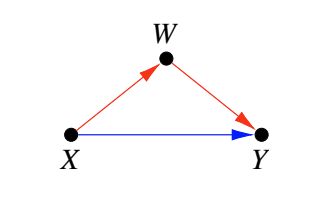

Figure 5.8: Causal diagram with treatment X,
outcome Y, and mediator W. The direct path
is shown in blue, and the
indirect one is shown in
red.

We define two counterfactuals, the Natural Direct Effect (NDE) and the Natural Indirect Effect (NIE) that capture the notions of direct and indirect effects. Both quantities represent constrasts and are defined as follows:
$$NDE_{x_0,x_1}(y) = P(y_{x_1,W_{x_0}}) - P(Y_{x_0})$$
$$NIE{x_0,x_1}(y) = P(y_{x_0,W_{x_1}}) - P(Y_{x_0})$$

For the NDE, the counterfactual $P(y_{x_1,W_{x_0}})$ refers to the outcome $Y$ under $X = x_1$ and $W = W_{x_0}$, the value that $W$ would attain had $X$ been $x_0$.

For the NIE, the counterfactual $P(y_{x_0,W_{x_1}})$ refers to the outcome $Y$ under $X = x_0$ and $W = W_{x_1}$, the value that $W$ would attain had $X$ been $x_1$.

$Y_{x_0}$ represents a baseline where $Y$ perceives $X$ as $x_0$ in all causal paths. It is equivalent to $Y_{x_0,W_{x_0}}$, a situation where $W$ gets the same $X=x_0$.
\
\
\
The structural basis expansion can be written as follows:
$$NDE_{x_0,x_1}(y) = \sum_u 1[y_{x_1,W_{x_0}}(u)] - 1[Y_{x_0}(u)] P(u)$$
$$NIE_{x_0,x_1}(y) = \sum_u 1[y_{x_0,W_{x_1}}(u)] - 1[Y_{x_0}(u)] P(u)$$

### Example 5.7 -- Exercise and Cholesterol

Consider the following diagram:

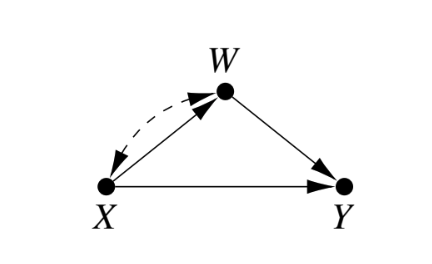

Suppose $X$ is the level of exercise (sufficient or insufficient), $W$ cholesterol levels (low or high), and $Y$ cardiovascular disease (present or not present).

We define the SCM as follows:

In [223]:
x, w, y, uwx, ux, uw, uy = sp.symbols('x w y uwx ux uw uy')

scm_5_7 = SymbolicSCM(
    f = {
        x: ux | uwx,
        w: (x & uwx) | (~x & uw),
        y: (~x & w) | (w & uy) | ~w
    },
    pu = {
        ux: .6,
        uwx: .3,
        uw: .5,
        uy: .1,
    }
)

An interesting question is how much exercise prevents the disease by means other than regulating cholesterol. This can be represented with the NDE. This query is identifiable and given by the expression:
$$\sum_w (P(y|x',w) - P(y|x,w))P(w|do(x))$$

We can calculate this expression using this identification expression:

In [224]:
scm_5_7_do_x0 = scm_5_7.do({x:0})

w_x0 = scm_5_7_do_x0.v.w

prob = 0

for w_val in range(2):
    prob += scm_5_7.query_exp((Pr({y:1},{x:1,w:w_val}) - Pr({y:1},{x:0,w:w_val})) * Pr({w_x0:w_val}))
    
prob

0

Or by directly accessing the counterfactual words implied by the NDE:

In [225]:
y_x1_wx0 = scm_5_7.do({x:1,w:w_x0}).v.y

y_x0 = scm_5_7_do_x0.v.y

scm_5_7.query_exp(Pr({y_x0:1}) + Pr({y_x1_wx0:1}),latex=True)

<IPython.core.display.Latex object>

This means that the direct effect of exercise ($X=1$) is to lower the probability of cardiovascular disease ($Y=1$) by 45%.

Analogously, the NIE refers to the question of how much the benefits of exercising on cardiovascular disease are due to the regulation of cholesterol. From the causal graph, this is identifiable as:

$$\sum_w P(y|x,w)(P(w|do(x')) - P(w|do(x)))$$

We can calculate this using the identification expression:

In [226]:
scm_5_7_do_x1 = scm_5_7.do({x:1})

w_x1 = scm_5_7_do_x1.v.w

prob = 0

for w_val in range(2):
    prob += scm_5_7.query({y:1},given={x:0,w:w_val}) * (scm_5_7.query({w_x1:w_val}) - scm_5_7.query({w_x0:w_val}))
    
prob

0.0

As before, we can also directly access the counterfactual worlds:

In [227]:
y_x0_wx1 = scm_5_7.do({x:0,w:w_x1}).v.y

scm_5_7.query({y_x0_wx1:1}) - scm_5_7.query({y_x0:1})

0.0

This means that the indirect effect of exercise on cardiovascular disease through the regulation of cholesterol does not alter the probability at all of cardiovascular disease at all.

## Path-Specific Effects

The NDE selects the direct path $X \rightarrow Y$ while the NIE selects all causal paths between X and Y but the direct one. Generally, counterfactuals can be used to reason about effects carried by a selected subset of edges, called *path-specific* events.

### Example 5.8 -- Education Cost on Debt

Consider the following causal diagram:

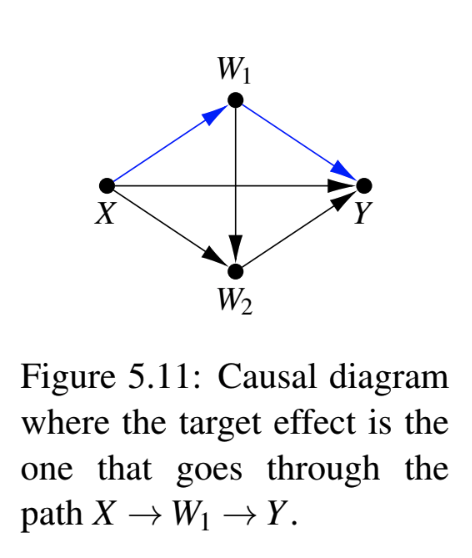

where $X$ represents choice of career (positive or negative), $W_1$ represents institution where one receives education (sufficient or insufficient), $W_2$ is the job attained after graduation (sufficient or insufficient), and $Y$ a person's debt (low or high).

The SCM is defined as follows:

In [228]:
x, w1, w2, y, ux, uw1, uw2, uy = sp.symbols('x w1 w2 y ux uw1 uw2 uy')

scm_5_8 = SymbolicSCM(
    f = {
        x: ux,
        w1: uw1,
        w2: uw2,
        y: (x & ~w1 & ~w2) | (~x & w1 & ~w2) | (~x & ~w1 & w2) | ~x
    },
    pu = {
        ux: .5,
        uw1: .3,
        uw2: .7,
        uy: .1
    }
)

Suppose the government is planning to lower people’s debt by partially paying off student loans. To do so, they want to assess the hypothetical situation where a
person chooses their career, institution, and job, but the cost generated by attending the institution
is set to the level of a low (or zero) cost program. In graphical terms, this is to assess the effect of
the path $X \rightarrow W_1 \rightarrow Y$.

This path-specific effect can be written as the following counterfactual:

$$P(Y_{X,W_2,W_{1[x']}}) = P(Y_{W_{1[x']}})$$

In [229]:
w_x1 = scm_5_8.do({x:1}).v.w1

y_wx1 = scm_5_8.do({w1:w_x1}).v.y

scm_5_8.query({y_wx1:1})

0.6049999999999999

This captures the path-specific event probability of low debt ($Y=1$) as controlled by sufficient education ($W=1$) having been intervened with a positive career choice ($do(X=1)$). Since $X$ and $W_2$ take on their natural values, they are not considered in the evaluation of the counterfactual world.